Installation de spark ,java ainsi que configuration

In [1]:

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!curl -L -o spark.tgz https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xzf spark.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  370M  100  370M    0     0  5733k      0  0:01:06  0:01:06 --:--:-- 17.5M


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Analyse des logs Apache") \
    .getOrCreate()

Chargement du fichier de logs

In [3]:

log_path = "/content/access_log_simulated.log"


if os.path.exists(log_path):

    raw_logs = spark.read.text(log_path)
    raw_logs.show(5, truncate=False)
else:
    print(f"Erreur: le fichier {log_path} n'existe pas.")


+---------------------------------------------------------------------------------------------+
|value                                                                                        |
+---------------------------------------------------------------------------------------------+
|192.168.1.33 - - [16/Jul/2020:11:54:48 +0000] "POST / HTTP/1.1" 200 759 "-" "Chrome"         |
|192.168.1.27 - - [16/Jul/2020:10:06:07 +0000] "GET /login HTTP/1.1" 400 143 "-" "Safari"     |
|192.168.1.44 - - [16/Jul/2020:10:12:38 +0000] "POST /login HTTP/1.1" 302 2126 "-" "Chrome"   |
|192.168.1.47 - - [16/Jul/2020:19:57:44 +0000] "PUT /contact HTTP/1.1" 500 1326 "-" "Safari"  |
|192.168.1.21 - - [16/Jul/2020:14:03:59 +0000] "POST /products HTTP/1.1" 503 1345 "-" "Chrome"|
+---------------------------------------------------------------------------------------------+
only showing top 5 rows



In [7]:
from pyspark.sql.functions import regexp_extract,col

# Pattern RegEx pour logs Apache (Common Log Format étendu)
log_pattern = r'^(\S+) \S+ \S+ \[([^\]]+)\] "(\S+) (\S+) (\S+)" (\d{3}) (\d+) ".*?" "(.*?)"$'

logs_df = raw_logs.select(
    regexp_extract('value', log_pattern, 1).alias('ip'),
    regexp_extract('value', log_pattern, 2).alias('timestamp'),
    regexp_extract('value', log_pattern, 3).alias('method'),
    regexp_extract('value', log_pattern, 4).alias('resource'),
    regexp_extract('value', log_pattern, 5).alias('protocol'),
    regexp_extract('value', log_pattern, 6).cast('integer').alias('status'),
    regexp_extract('value', log_pattern, 7).cast('integer').alias('size'),
    regexp_extract('value', log_pattern, 8).alias('user_agent')
)

logs_df.show(5, truncate=False)


+------------+--------------------------+------+---------+--------+------+----+----------+
|ip          |timestamp                 |method|resource |protocol|status|size|user_agent|
+------------+--------------------------+------+---------+--------+------+----+----------+
|192.168.1.33|16/Jul/2020:11:54:48 +0000|POST  |/        |HTTP/1.1|200   |759 |Chrome    |
|192.168.1.27|16/Jul/2020:10:06:07 +0000|GET   |/login   |HTTP/1.1|400   |143 |Safari    |
|192.168.1.44|16/Jul/2020:10:12:38 +0000|POST  |/login   |HTTP/1.1|302   |2126|Chrome    |
|192.168.1.47|16/Jul/2020:19:57:44 +0000|PUT   |/contact |HTTP/1.1|500   |1326|Safari    |
|192.168.1.21|16/Jul/2020:14:03:59 +0000|POST  |/products|HTTP/1.1|503   |1345|Chrome    |
+------------+--------------------------+------+---------+--------+------+----+----------+
only showing top 5 rows



Analyses


In [5]:
#top 10 ip les plus fréquentes
logs_df.groupBy("ip").count().orderBy("count", ascending=False).show(10)


+------------+-----+
|          ip|count|
+------------+-----+
| 192.168.1.3|  234|
|192.168.1.46|  229|
|192.168.1.41|  228|
|192.168.1.42|  225|
|192.168.1.38|  223|
| 192.168.1.6|  222|
|192.168.1.13|  216|
|192.168.1.37|  215|
|192.168.1.26|  214|
|192.168.1.24|  214|
+------------+-----+
only showing top 10 rows



In [6]:
#nbre de requêtes par code de statut http
logs_df.groupBy("status").count().orderBy("count", ascending=False).show()


+------+-----+
|status|count|
+------+-----+
|   400| 1134|
|   200| 1127|
|   302| 1127|
|   503| 1126|
|   404| 1120|
|   403| 1117|
|   500| 1095|
|   201| 1085|
|   301| 1069|
+------+-----+



In [8]:
#requêtes contenant de erreurs
logs_df.filter((col("status") >= 400) & (col("status") < 600)).show(10)


+------------+--------------------+------+---------+--------+------+----+----------+
|          ip|           timestamp|method| resource|protocol|status|size|user_agent|
+------------+--------------------+------+---------+--------+------+----+----------+
|192.168.1.27|16/Jul/2020:10:06...|   GET|   /login|HTTP/1.1|   400| 143|    Safari|
|192.168.1.47|16/Jul/2020:19:57...|   PUT| /contact|HTTP/1.1|   500|1326|    Safari|
|192.168.1.21|16/Jul/2020:14:03...|  POST|/products|HTTP/1.1|   503|1345|    Chrome|
|192.168.1.37|16/Jul/2020:07:55...|   PUT|/products|HTTP/1.1|   403|2363|   Mozilla|
|192.168.1.19|16/Jul/2020:04:28...|  POST| /contact|HTTP/1.1|   500|4652|    Chrome|
|192.168.1.48|16/Jul/2020:05:17...|   GET|    /home|HTTP/1.1|   403|2297|    Safari|
|192.168.1.30|16/Jul/2020:15:38...|   PUT|    /home|HTTP/1.1|   503|2663|      Edge|
|192.168.1.24|16/Jul/2020:02:49...|  POST|/products|HTTP/1.1|   404|2756|    Chrome|
|192.168.1.34|16/Jul/2020:15:30...|   GET|        /|HTTP/1.1|   4

Analyse du traffic par heure et visualisation des erreurs HTTP

Extraction de l'heure timestamp

In [9]:
from pyspark.sql.functions import to_timestamp, hour

logs_df = logs_df.withColumn("datetime", to_timestamp("timestamp", "dd/MMM/yyyy:HH:mm:ss +0000"))
logs_df = logs_df.withColumn("hour", hour("datetime"))


Nbre de requêtes par heures

In [10]:
requests_by_hour = logs_df.groupBy("hour").count().orderBy("hour")
requests_by_hour.show()


+----+-----+
|hour|count|
+----+-----+
|   0|  430|
|   1|  428|
|   2|  434|
|   3|  386|
|   4|  408|
|   5|  428|
|   6|  404|
|   7|  416|
|   8|  426|
|   9|  427|
|  10|  411|
|  11|  390|
|  12|  407|
|  13|  405|
|  14|  434|
|  15|  425|
|  16|  451|
|  17|  382|
|  18|  425|
|  19|  415|
+----+-----+
only showing top 20 rows



Nbre d'erreurs par heure

In [11]:
errors_by_hour = logs_df.filter((col("status") >= 400) & (col("status") < 600)) \
                        .groupBy("hour").count().orderBy("hour")
errors_by_hour.show()


+----+-----+
|hour|count|
+----+-----+
|   0|  240|
|   1|  219|
|   2|  245|
|   3|  206|
|   4|  233|
|   5|  241|
|   6|  220|
|   7|  233|
|   8|  227|
|   9|  237|
|  10|  245|
|  11|  213|
|  12|  231|
|  13|  215|
|  14|  266|
|  15|  244|
|  16|  250|
|  17|  211|
|  18|  249|
|  19|  229|
+----+-----+
only showing top 20 rows



Visualisation

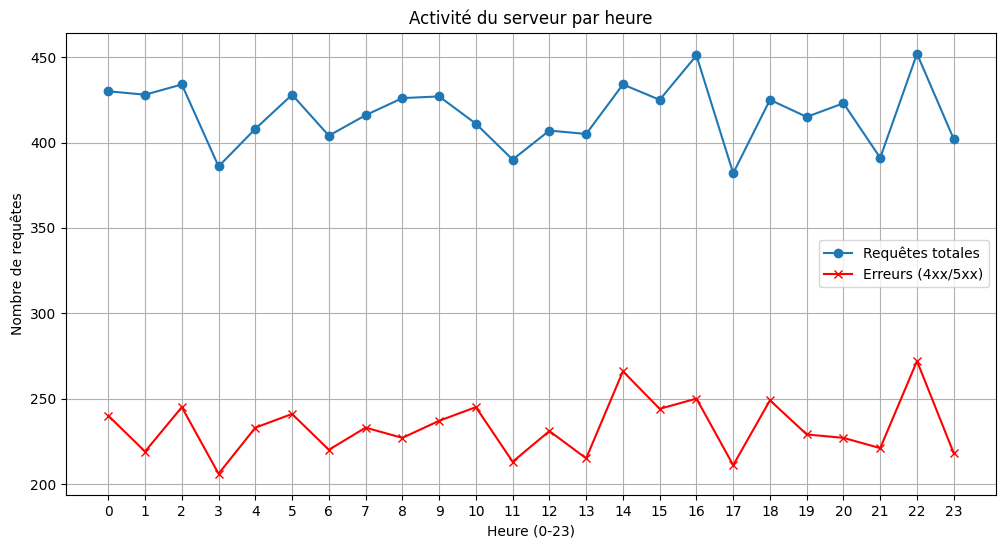

In [12]:
import matplotlib.pyplot as plt

# Convertion des deux DataFrames Spark en Pandas
req_pd = requests_by_hour.toPandas()
err_pd = errors_by_hour.toPandas()


plt.figure(figsize=(12, 6))
plt.plot(req_pd['hour'], req_pd['count'], marker='o', label="Requêtes totales")
plt.plot(err_pd['hour'], err_pd['count'], marker='x', label="Erreurs (4xx/5xx)", color="red")
plt.title("Activité du serveur par heure")
plt.xlabel("Heure (0-23)")
plt.ylabel("Nombre de requêtes")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()
